In [4]:
!pip install -e ..

Obtaining file:///root/gdrive/MyDrive/giotto-deep
  Attempting uninstall: giotto-deep
    Found existing installation: giotto-deep 0.0.1
    Can't uninstall 'giotto-deep'. No files were found to uninstall.
  Running setup.py develop for giotto-deep


In [1]:
%load_ext autoreload
%autoreload 2

import time
from os.path import join
import numpy as np
import torch
import matplotlib.pyplot as plt  # type: ignore
from sklearn.manifold import MDS  # type: ignore
from matplotlib.pylab import matshow  # type: ignore
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D  # type: ignore
import pandas as pd  # type: ignore
import plotly.express as px  # type: ignore

from gtda.diagrams import PairwiseDistance  # type: ignore

from gdeep.topology_layers import load_data_as_tensor


In [2]:
dataset_name = "PROTEINS"

x_pds, x_features, y = load_data_as_tensor(dataset_name)



In [3]:
# compute pairwise bottleneck distance of diagrams
# takes about 200 seconds = 3:20 minutes for COX2
diagrams = []
t = time.time()
n_graphs = len(x_pds)  # type: ignore
for i in range(n_graphs):
    x = torch.max(x_pds[i, :, 2:], dim=-1).indices
    x_pts = x_pds[i, :, :2]
    diagrams.append(torch.cat((x_pts, x.reshape(-1, 1)), dim=-1)
                    .detach().numpy())

distances = np.zeros(())
for type_ in range(int(max(diagrams[0][:, 2]) + 1.0)):
    max_size = max([(diagrams[idx][:, 2] == type_).sum()
                    for idx in range(len(diagrams))])
    pds = []
    for idx in range(len(diagrams)):
        pd_type = diagrams[idx][diagrams[idx][:, 2] == type_]
        pd_type_pad = np.pad(pd_type,
                             ((0, max_size - pd_type.shape[0]), (0, 0)),
                             'constant')
        pd_type_pad[:, 2] = type_
        pds.append(pd_type_pad)
    pwd = PairwiseDistance(metric='bottleneck', n_jobs=60)
    distances_type = pwd.fit_transform(np.stack(pds))
    distances = distances + distances_type**2
distances.shape
distances = np.sqrt(distances)
print(time.time() - t)

239.8497281074524


In [10]:
np.savetxt(join('graph_data', dataset_name, 'distances_' + dataset_name +
                '.txt'), distances)

In [11]:
distances = np.loadtxt(join('graph_data', dataset_name,
                            'distances_' + dataset_name + '.txt'))


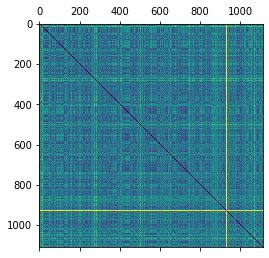

In [12]:
matshow(distances)
plt.show()

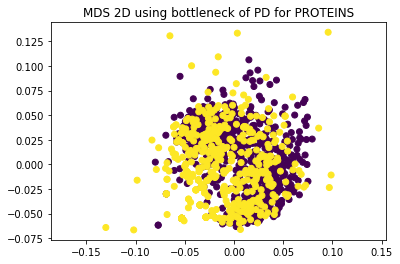

In [4]:
D = distances
D = 0.5 * (D + D.transpose())

dim = 2
model = MDS(n_components=dim, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)

if dim == 2:
    plt.scatter(out[:, 0], out[:, 1], c=y)
    plt.axis('equal')
    plt.title("MDS 2D using bottleneck of PD for " + dataset_name)
    plt.show()
if dim == 3:
    fig = pyplot.figure()
    ax = Axes3D(fig)
    ax.scatter(out[:, 0], out[:, 1], out[:, 2], c=y)
    plt.title("MDS 3D using bottleneck of PD for " + dataset_name)
    pyplot.show()

In [5]:

out_pd = pd.DataFrame(out)
out_pd['label'] = y
fig = px.scatter_3d(out_pd, x=0, y=1, z=2,
                    color='label')
fig.show()

ValueError: Value of 'z' is not the name of a column in 'data_frame'. Expected one of [0, 1, 'label'] but received: 2